# Conversion From a LIF network to DynapSim Network

In [1]:
# - Rockpool imports
from rockpool import TSEvent, TSContinuous
from rockpool.nn.modules import LIFJax, LinearJax, ExpSynJax
from rockpool.nn.modules.jax.jax_lif_ode import LIFODEJax
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Numpy
import numpy as np
import seaborn as sns
from rockpool.devices.dynapse import (
    mapper,
    parameter_clustering,
    autoencoder_quantization,
    config_from_specification,
    dynapsim_from_graph,
    dynapsim_from_config,
)

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# - Network size
Nin = 12
N1 = 20
N2 = 8
N3 = 4
input_scale = 20.
dt = 1e-3

In [3]:
# - Generate a network using the sequential combinator
modFFwd = Sequential(
    LinearJax((Nin, N1), has_bias = False), # 30x20
    LIFODEJax((N1, N1), dt = dt, has_rec=True), # 40x40
    LinearJax((N1, N2), has_bias = False), # 30x20
    LIFODEJax((N2, N2), dt = dt, has_rec=True), # 40x40
    LinearJax((N2, N3), has_bias = False), # 30x20
    LIFODEJax((N3, N3), dt = dt, has_rec=True), # 40x40
)

print(modFFwd)

JaxSequential  with shape (12, 4) {
    LinearJax '0_LinearJax' with shape (12, 20)
    LIFODEJax '1_LIFODEJax' with shape (20, 20)
    LinearJax '2_LinearJax' with shape (20, 8)
    LIFODEJax '3_LIFODEJax' with shape (8, 8)
    LinearJax '4_LinearJax' with shape (8, 4)
    LIFODEJax '5_LIFODEJax' with shape (4, 4)
}


In [4]:
from rockpool.devices.dynapse import DynapseNeurons

In [5]:
from rockpool.graph.utils import bag_graph, find_recurrent_modules

mod_graph = modFFwd.as_graph()
modules, rec_modules = find_recurrent_modules(mod_graph)

In [6]:
modules

[LinearWeights "LinearJax_'0_LinearJax'_11382696032" with 12 input nodes -> 20 output nodes,
 LinearWeights "LIFODEJax_recurrent_'1_LIFODEJax'_11382686480" with 20 input nodes -> 20 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'1_LIFODEJax'_11382686480" with 20 input nodes -> 20 output nodes,
 LinearWeights "LinearJax_'2_LinearJax'_11382695936" with 20 input nodes -> 8 output nodes,
 LinearWeights "LIFODEJax_recurrent_'3_LIFODEJax'_11535657584" with 8 input nodes -> 8 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'3_LIFODEJax'_11535657584" with 8 input nodes -> 8 output nodes,
 LinearWeights "LinearJax_'4_LinearJax'_11535657536" with 8 input nodes -> 4 output nodes,
 LinearWeights "LIFODEJax_recurrent_'5_LIFODEJax'_11535738352" with 4 input nodes -> 4 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'5_LIFODEJax'_11535738352" with 4 input nodes -> 4 output nodes]

In [7]:
rec_modules

[LinearWeights "LIFODEJax_recurrent_'1_LIFODEJax'_11382686480" with 20 input nodes -> 20 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'1_LIFODEJax'_11382686480" with 20 input nodes -> 20 output nodes,
 LinearWeights "LIFODEJax_recurrent_'3_LIFODEJax'_11535657584" with 8 input nodes -> 8 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'3_LIFODEJax'_11535657584" with 8 input nodes -> 8 output nodes,
 LinearWeights "LIFODEJax_recurrent_'5_LIFODEJax'_11535738352" with 4 input nodes -> 4 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'5_LIFODEJax'_11535738352" with 4 input nodes -> 4 output nodes]

In [8]:
mod_se2 = dynapsim_from_graph(modFFwd.as_graph())
mod_se2

JaxSequential  with shape (12, 32) {
    LinearJax '0_LinearJax' with shape (12, 32)
    DynapSim '1_DynapSim' with shape (32, 32)
}

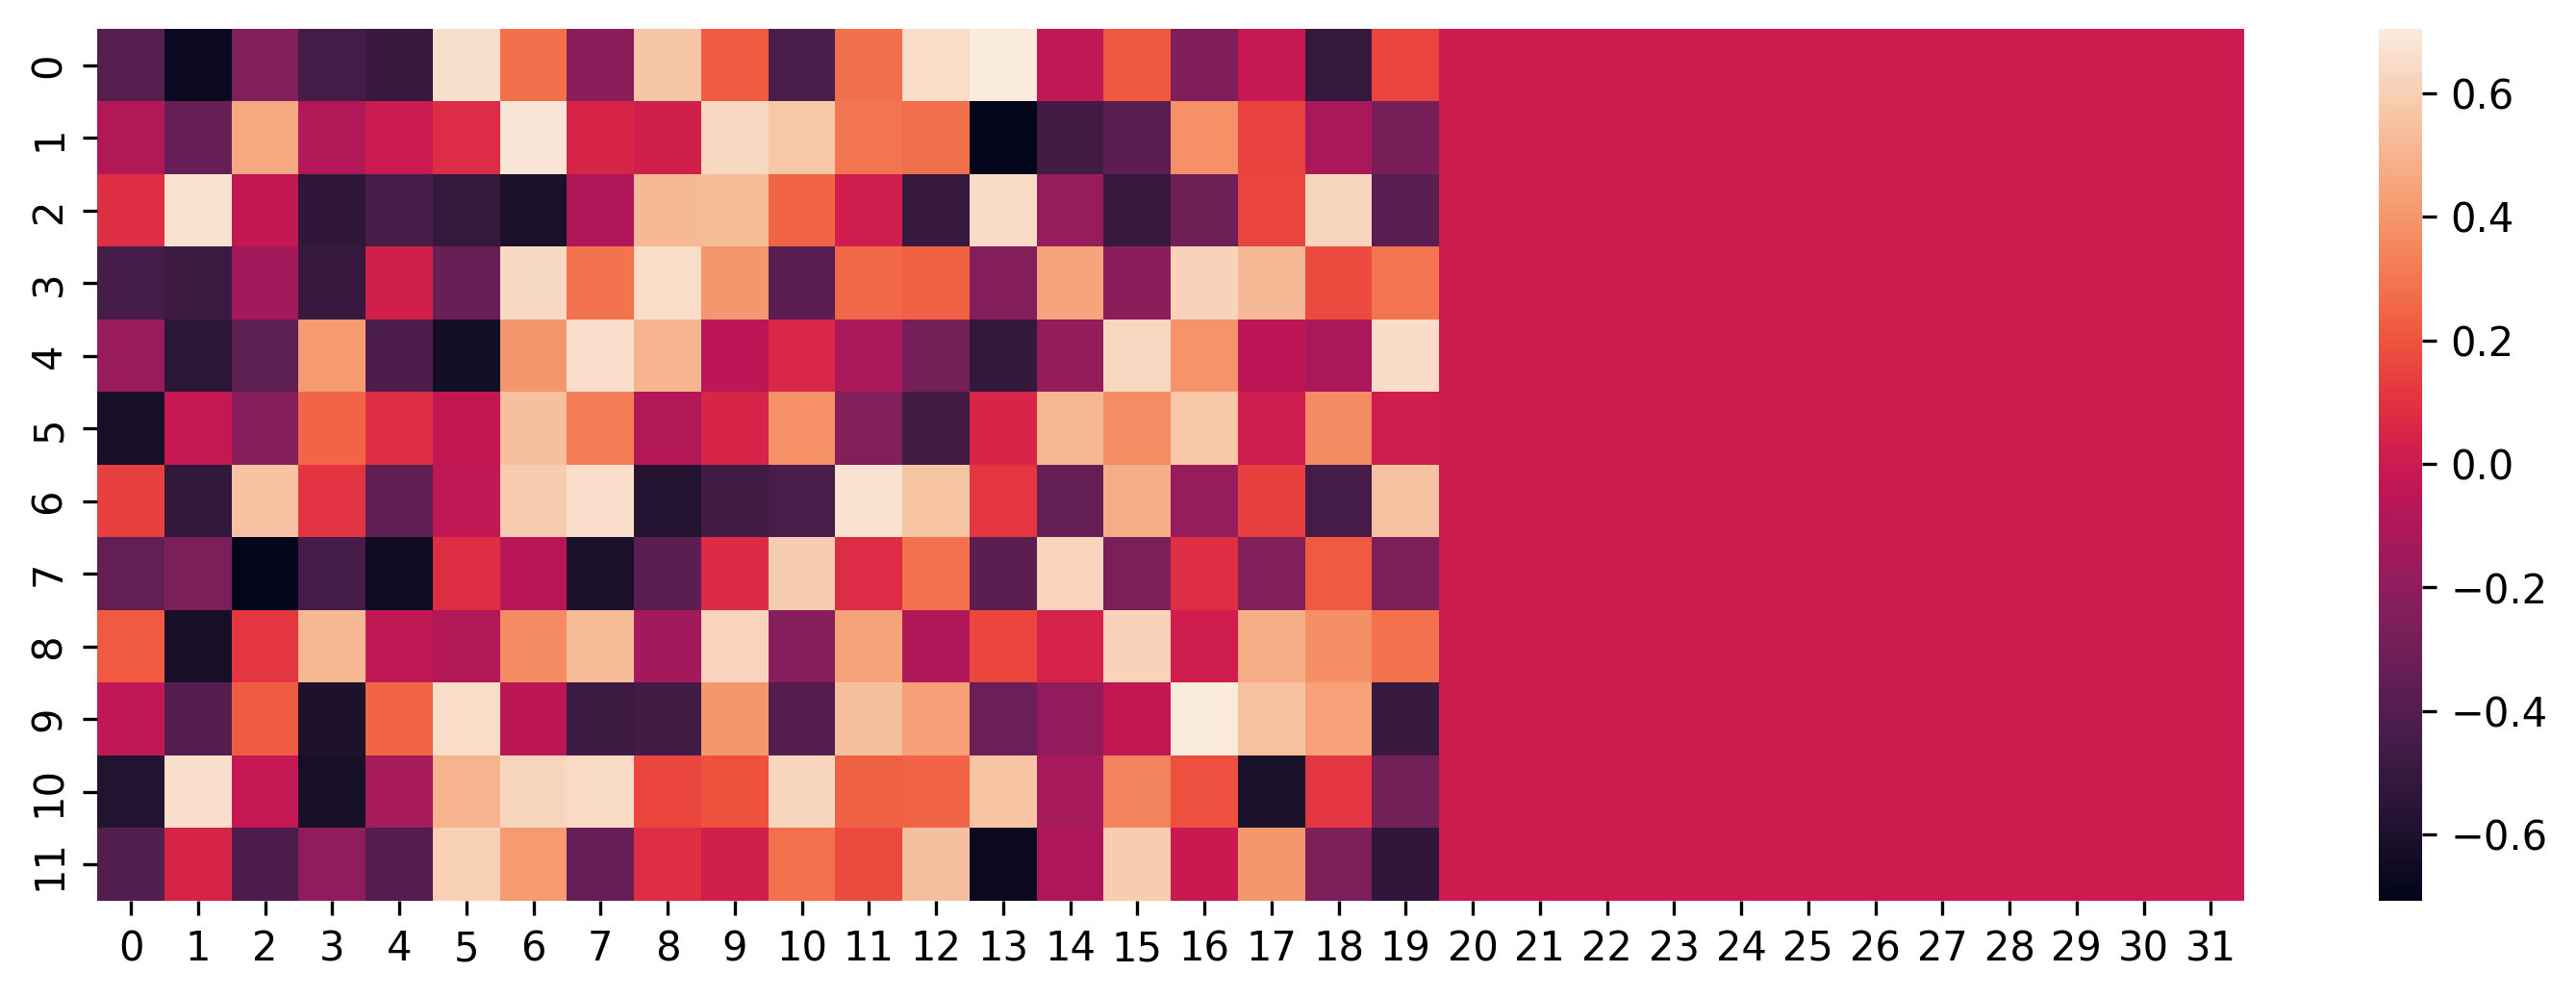

In [9]:
ax = sns.heatmap(mod_se2[0].weight)
plt.show()

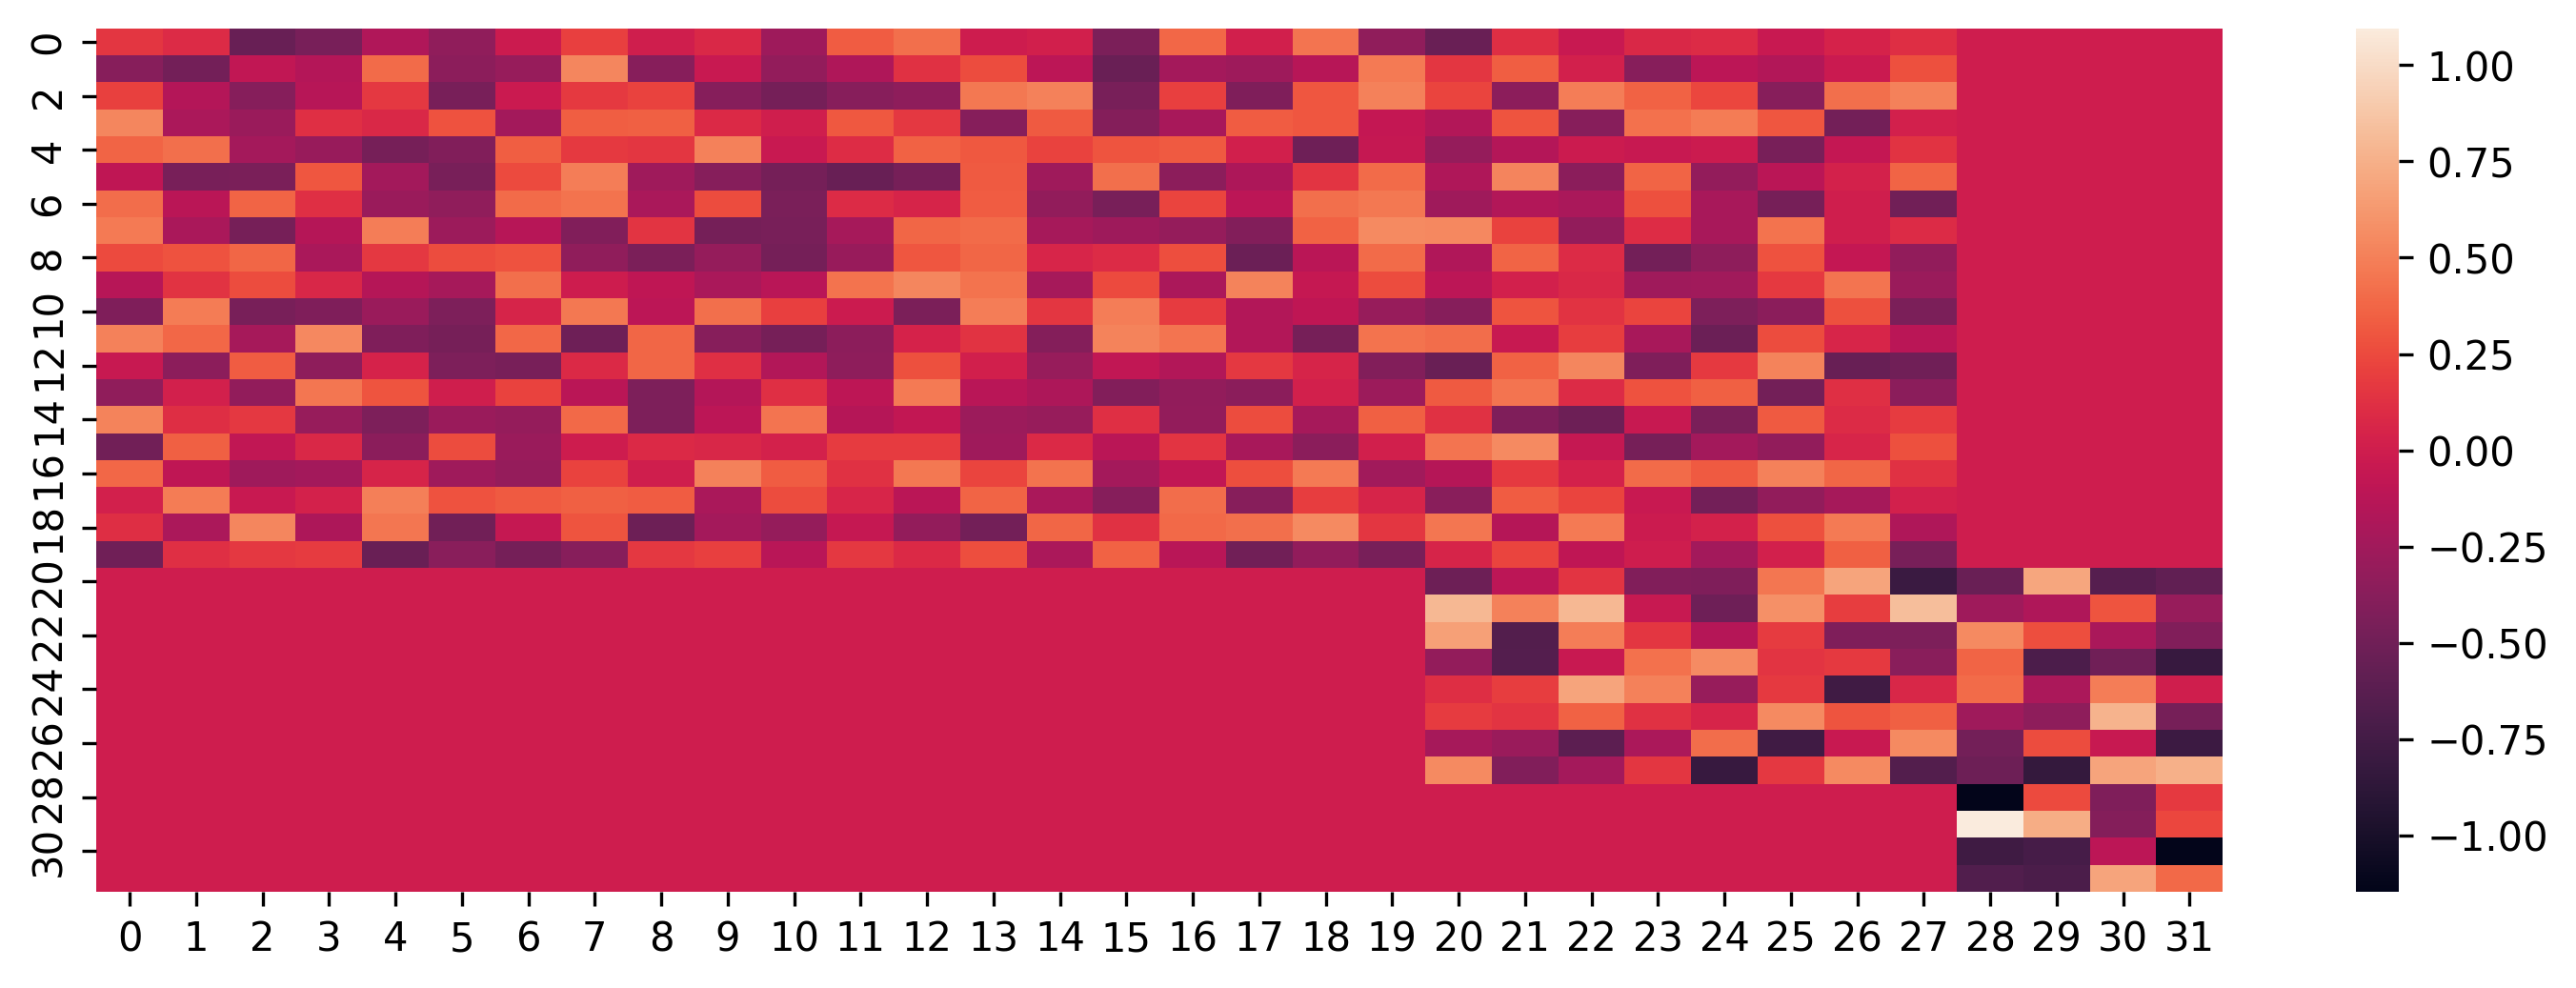

In [10]:
ax = sns.heatmap(mod_se2[1].w_rec)


In [11]:
spec = mapper(modFFwd.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__11535744160_transformed_SE_11623364736" with 12 input nodes -> 32 output nodes,
 'weights_in': array([[-0.3947415 , -0.66925477, -0.24087991, -0.44932164, -0.50239096,
          0.66346215,  0.27618894, -0.20959731,  0.56643879,  0.22305769,
         -0.43270034,  0.27439446,  0.65084684,  0.70215345, -0.0372014 ,
          0.20992747, -0.24975256, -0.01355295, -0.51030288,  0.15648214,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [-0.08576759, -0.33739173,  0.46420069, -0.08590232, -0.006027  ,
          0.07603116,  0.6857708 ,  0.04745187,  0.02266172,  0.63188049,
          0.56740207,  0.29637152,  0.27514645, -0.7069051 , -0.46879646,
         -0.36899741,  0.38099221,  0.15198139, -0.11806344, -0.27393726,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0

In [12]:
spec.update(parameter_clustering(**spec))
spec


{'mapped_graph': GraphHolder "JaxSequential__11535744160_transformed_SE_11623364736" with 12 input nodes -> 32 output nodes,
 'weights_in': array([[-0.3947415 , -0.66925477, -0.24087991, -0.44932164, -0.50239096,
          0.66346215,  0.27618894, -0.20959731,  0.56643879,  0.22305769,
         -0.43270034,  0.27439446,  0.65084684,  0.70215345, -0.0372014 ,
          0.20992747, -0.24975256, -0.01355295, -0.51030288,  0.15648214,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [-0.08576759, -0.33739173,  0.46420069, -0.08590232, -0.006027  ,
          0.07603116,  0.6857708 ,  0.04745187,  0.02266172,  0.63188049,
          0.56740207,  0.29637152,  0.27514645, -0.7069051 , -0.46879646,
         -0.36899741,  0.38099221,  0.15198139, -0.11806344, -0.27393726,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0

In [13]:
spec.update(autoencoder_quantization(**spec))
spec


{'mapped_graph': GraphHolder "JaxSequential__11535744160_transformed_SE_11623364736" with 12 input nodes -> 32 output nodes,
 'weights_in': [array([[ 6, 15, 10, 14, 14, 15, 12,  3, 15,  3, 14,  8, 15, 15,  2,  2,
           8,  0, 13,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 4, 12, 14,  1,  0,  0, 15,  0,  0, 15, 13,  3,  3, 15, 14,  9,
          13,  1,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 8, 15,  0, 13,  7, 15, 15,  0, 13, 13,  1,  0, 13, 15,  1, 13,
           6,  4, 15, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [13, 13,  0, 13,  2, 10, 15,  1, 15,  7, 14,  6,  2,  5, 13, 10,
          15, 14,  8,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1, 15,  7,  9, 13, 15,  7, 15, 13,  4,  0,  1, 12, 11,  8, 15,
          10,  8,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [15,  0,  6,  1,  8,  0, 15, 10,  0,  0, 14,  9, 13,  0, 11, 14,
          14,  0,  5,  0,  0,  0,  0,  0, 

In [14]:
config, input_channel_map = config_from_specification(**spec)

In [15]:
mod_se2_reconstructed = dynapsim_from_config(config)

In [16]:
from rockpool.devices.dynapse.quantization import WeightHandler

In [17]:
mod_se2_reconstructed[0].weight

array([[-0.30853505, -0.62711892, -0.30167832, -0.4611422 , -0.4611422 ,
         0.62711892,  0.31207103, -0.3150479 ,  0.62711892,  0.3150479 ,
        -0.4611422 ,  0.15260715,  0.62711892,  0.62711892, -0.14907117,
         0.14907117, -0.15260715,  0.        , -0.47804775,  0.16597673,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.15946388, -0.31207103,  0.4611422 , -0.16597673, -0.        ,
         0.        ,  0.62711892,  0.        ,  0.        ,  0.62711892,
         0.47804775,  0.3150479 ,  0.3150479 , -0.62711892, -0.4611422 ,
        -0.31858387,  0.47804775,  0.16597673, -0.        , -0.31207103,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.15260715,  0.62711892, -0.        , -0.4780

In [18]:
int_mask = np.array(spec["weights_in"])
sign_mask = np.array(spec["sign_in"])
Iw = np.array([spec["Iw_0"], spec["Iw_1"], spec["Iw_2"], spec["Iw_3"]]).T
w_in_q = WeightHandler.restore_weight_matrix(n_bits=4, code=Iw, int_mask=int_mask, sign_mask=sign_mask) / mod_se2_reconstructed[1].Iscale

In [19]:
mod_se2_reconstructed[0].weight

array([[-0.30853505, -0.62711892, -0.30167832, -0.4611422 , -0.4611422 ,
         0.62711892,  0.31207103, -0.3150479 ,  0.62711892,  0.3150479 ,
        -0.4611422 ,  0.15260715,  0.62711892,  0.62711892, -0.14907117,
         0.14907117, -0.15260715,  0.        , -0.47804775,  0.16597673,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.15946388, -0.31207103,  0.4611422 , -0.16597673, -0.        ,
         0.        ,  0.62711892,  0.        ,  0.        ,  0.62711892,
         0.47804775,  0.3150479 ,  0.3150479 , -0.62711892, -0.4611422 ,
        -0.31858387,  0.47804775,  0.16597673, -0.        , -0.31207103,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.15260715,  0.62711892, -0.        , -0.4780

In [20]:
w_in_q[0]

array([[-0.30761746, -0.62658334, -0.30093706, -0.45908517, -0.45908517,
         0.62658334,  0.30961585, -0.31696746,  0.62658334,  0.31696746,
        -0.45908517,  0.15146771,  0.62658334,  0.62658334, -0.14946933,
         0.14946933, -0.15146771, -0.        , -0.47711396,  0.16749811,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.15814812, -0.30961585,  0.45908517, -0.16749811, -0.        ,
         0.        ,  0.62658334,  0.        ,  0.        ,  0.62658334,
         0.47711396,  0.31696746,  0.31696746, -0.62658334, -0.45908517,
        -0.31896582,  0.47711396,  0.16749811, -0.        , -0.30961585,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.15146771,  0.62658334, -0.        , -0.4771

### Values are close but not exactly the same!!!

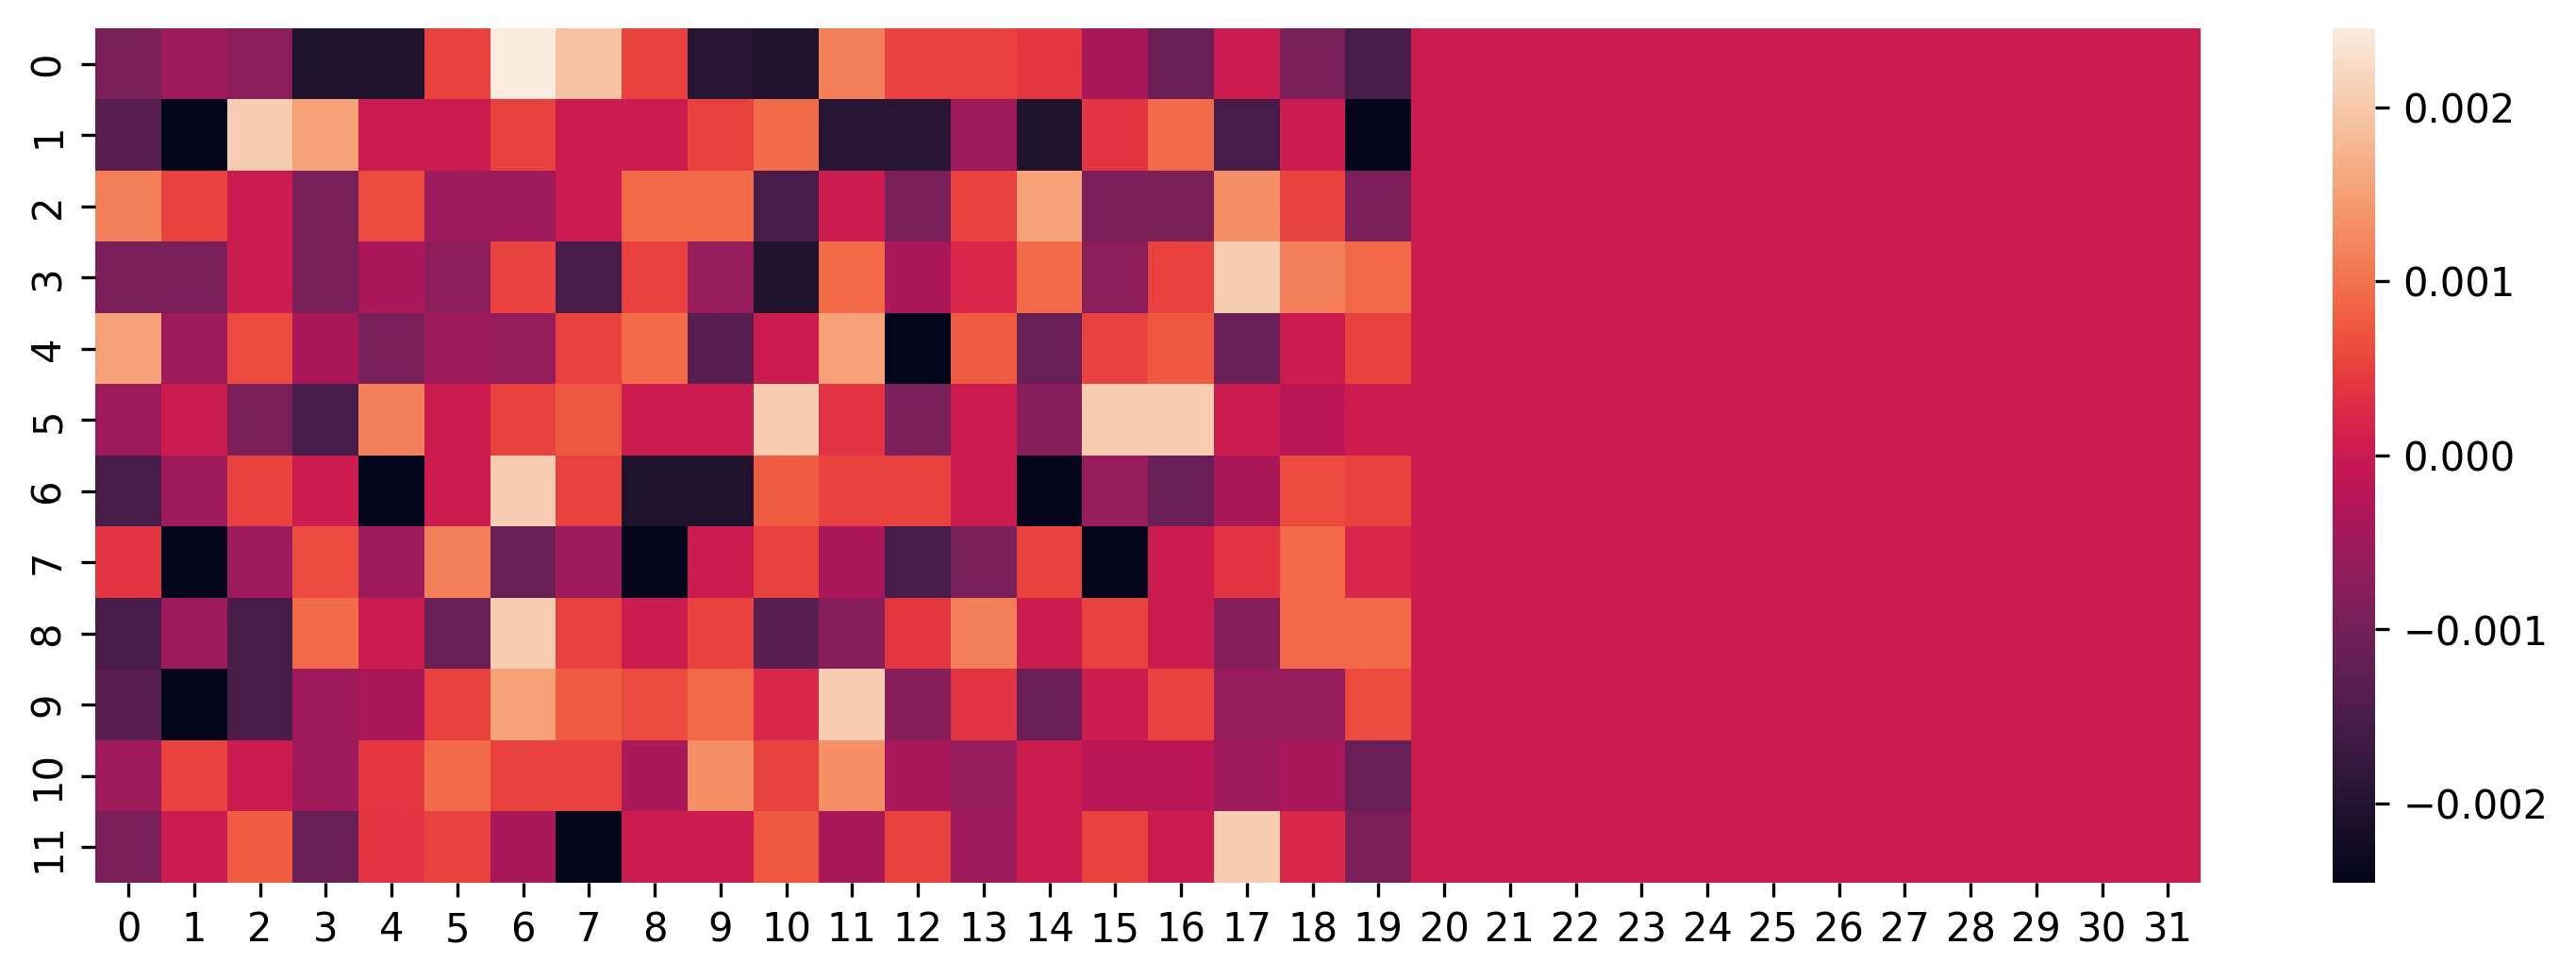

In [21]:
ax = sns.heatmap(mod_se2_reconstructed[0].weight - w_in_q[0])
plt.show()